In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from final_project.smlm_3d.config.datasets import dataset_configs
# from final_project.smlm_3d.data.datasets import TrainingDataSet, ExperimentalDataSet
# from final_project.smlm_3d.workflow_v2 import concat_dataset_features


# z_range = 1000




# dataset = 'paired_bead_stacks'


# train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=True, add_noise=False, filter_emitters_proximity=False, filter_low_intensity_emitters=False, split_data=True)

# exp_dataset = TrainingDataSet(dataset_configs[dataset]['experimental'], z_range, transform_data=True, add_noise=False, split_data=False)
# concat_dataset_features(train_dataset.data)
# concat_dataset_features(exp_dataset.data)

In [3]:
# import tensorflow as tf
# from tensorflow import keras
# data = train_dataset.data['all']
# model = keras.Sequential()
# model.add(keras.layers.Dense(1000))

# opt = keras.optimizers.Adam(learning_rate=0.1)

# metrics = [
#     keras.metrics.MeanAbsoluteError()
# ]
# model.compile(optimizer=opt, loss='mse', metrics=metrics)
# # This builds the model for the first time:

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=3,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0,
# )


# callbacks = [
#     reduce_lr
# ]

# model.fit(*data, batch_size=512, epochs=100, verbose=True, callbacks=reduce_lr, validation_data=tuple(exp_dataset.data['all']))

In [13]:
# from final_project.smlm_3d.workflow_v2 import load_model, eval_model, shift_correction, train_model


# '''
# DWT model
# '''
# # model = load_model()

# model = train_model(train_dataset.data, val_dataset=exp_dataset.data['all'])

In [5]:
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import TrainingDataSet, ExperimentalDataSet
from final_project.smlm_3d.workflow_v2 import concat_dataset_features


z_range = 1000




dataset = 'paired_bead_stacks'


train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=False, add_noise=False, filter_emitters_proximity=False, filter_low_intensity_emitters=False, split_data=True)

exp_dataset = TrainingDataSet(dataset_configs[dataset]['experimental'], z_range, transform_data=False, add_noise=False, split_data=False)
# concat_dataset_features(train_dataset.data)
# concat_dataset_features(exp_dataset.data)

  2%|▏         | 16/699 [00:00<00:04, 151.84it/s]

Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/Original_FOV_647nm_300ms_2binning/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/Original_FOV_647nm_300ms_2binning/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.csv
724 emitters before filtering
699 emitters after borders


100%|██████████| 699/699 [00:04<00:00, 167.34it/s]


68.2 56.6
24.5 15.3
349 emitters after fitting plane


  6%|▌         | 14/247 [00:00<00:01, 133.01it/s]

Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/70.2um_FOV_to_left_of_original_FOV/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/70.2um_FOV_to_left_of_original_FOV/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.csv
724 emitters before filtering
264 emitters after proximity filtering.
247 emitters after borders


100%|██████████| 247/247 [00:01<00:00, 163.96it/s]


57.7 50.7
23.3 13.1
123 emitters after fitting plane


(48556, 32, 32, 1)
(48556, 1)
(48556,)
Epoch 1/500
190/190 [==============================] - 12s 29ms/step - loss: 97480.1328 - mean_absolute_error: 211.6355 - val_loss: 435396.7812 - val_mean_absolute_error: 548.2070 - lr: 1.0000e-04
Epoch 2/500
190/190 [==============================] - 5s 24ms/step - loss: 9304.8457 - mean_absolute_error: 72.5274 - val_loss: 198088.7188 - val_mean_absolute_error: 316.9326 - lr: 1.0000e-04
Epoch 3/500
190/190 [==============================] - 5s 24ms/step - loss: 6726.4326 - mean_absolute_error: 64.0940 - val_loss: 88804.5156 - val_mean_absolute_error: 184.0469 - lr: 1.0000e-04
Epoch 4/500
190/190 [==============================] - 5s 24ms/step - loss: 6471.8477 - mean_absolute_error: 62.6612 - val_loss: 76162.9531 - val_mean_absolute_error: 189.3017 - lr: 1.0000e-04
Epoch 5/500
190/190 [==============================] - 4s 23ms/step - loss: 6124.9966 - mean_absolute_error: 60.9171 - val_loss: 49702.4688 - val_mean_absolute_error: 152.9637 - lr: 1.

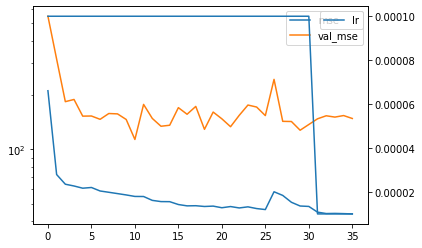

INFO:tensorflow:Assets written to: /home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/assets
Saved model!


In [6]:
from final_project.smlm_3d.experiments.deep_learning import load_model, train_model, save_model

model = train_model(train_dataset.data, exp_dataset.data['all'])
save_model(model)
# model = load_model()

In [7]:
'''
Check performance on training data
'''
from final_project.smlm_3d.workflow_v2 import shift_correction
from scipy.spatial.distance import cdist
from final_project.smlm_3d.data.visualise import scatter_3d, show_psf_axial

dataset = exp_dataset

ds = dataset.data['all']
df = dataset.csv_data

# pred_y = model.predict(ds[0]).squeeze()
# print(pred_y.shape)
# true_y = ds[1]
# pred_y = shift_correction(true_y, pred_y)


In [8]:
import numpy as np
true_y = ds[1]

# Chunk dataset into stacks and measure localisation error across stacks
edge_indices = [i+1 for i in range(len(true_y)-1) if true_y[i] > true_y[i+1]] + [len(true_y)]

start_idx = 0

psfs = []
true_ys = []
pred_ys = []
mean_errors = []
while len(edge_indices):
    end_idx = edge_indices.pop(0)
    true_sec = true_y[start_idx:end_idx]
    psf = ds[0][0][start_idx:end_idx]
    coords = ds[0][1][start_idx:end_idx]
    true_ys.append(true_sec)
    psfs.append(psf)
    start_idx = end_idx
    
    pred_y = model.predict([psf, coords]).squeeze()
    pred_ys.append(pred_y)
    
    mean_error = np.mean(abs(pred_y - true_sec))
    mean_errors.append(mean_error)


In [9]:
print(len(df))
print(len(psfs))
print(len(true_ys))
print(len(pred_ys))
print(len(mean_errors))

123
123
123
123
123


[679.0183668429733, 324.6442051456747, 305.8126591391339, 229.35876869392013, 212.63973734468934, 205.78856495998235, 198.3565598225775, 189.47676828830987, 180.248862942436, 177.956130701485]
done


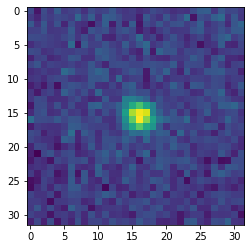

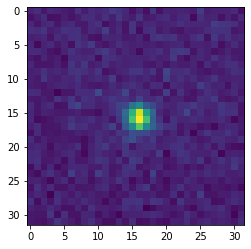

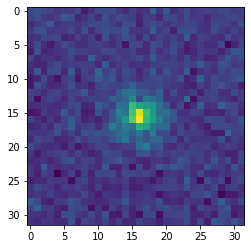

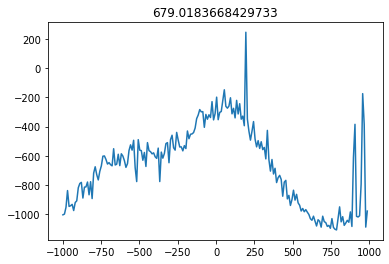

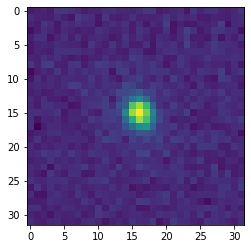

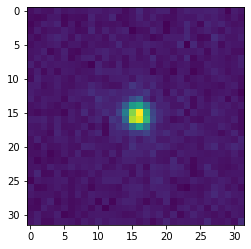

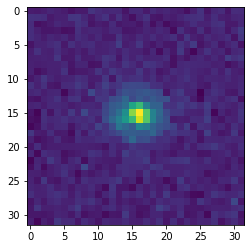

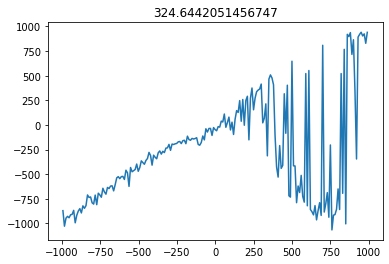

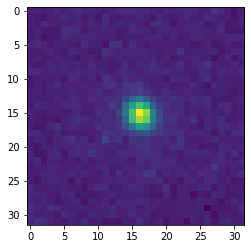

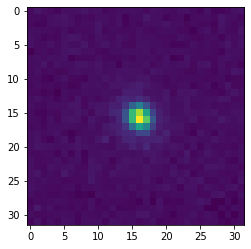

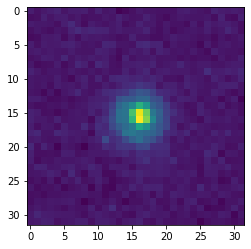

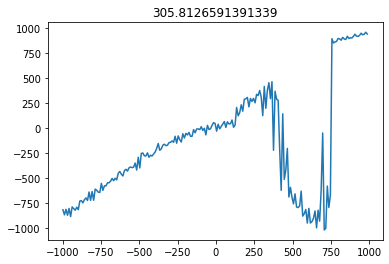

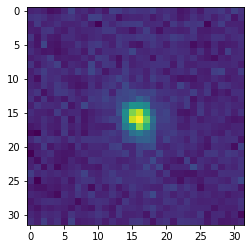

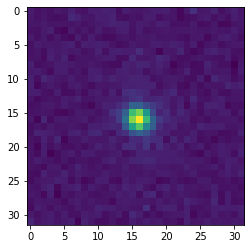

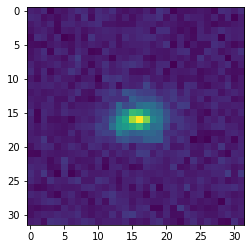

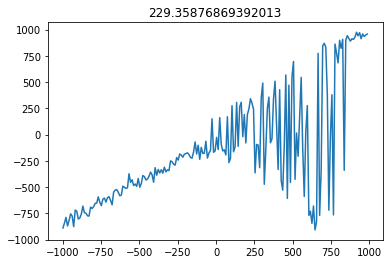

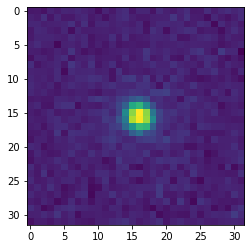

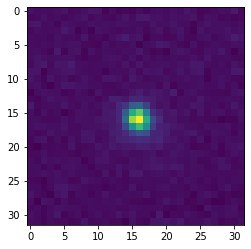

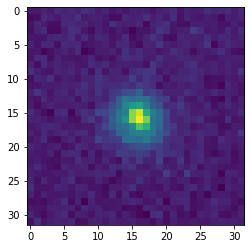

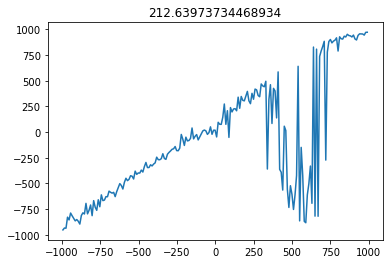

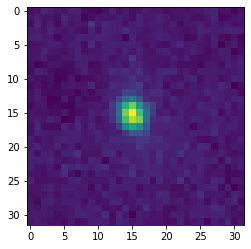

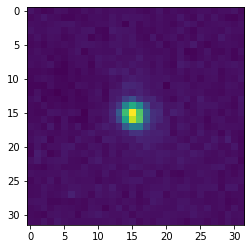

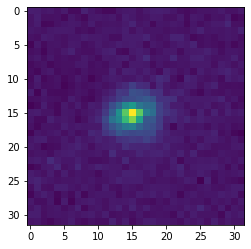

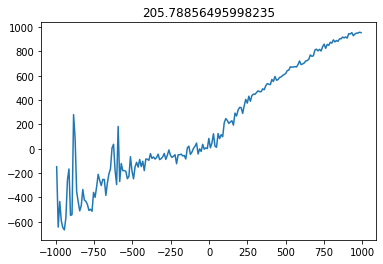

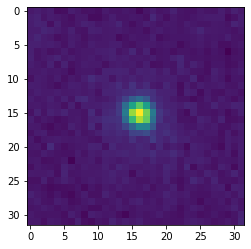

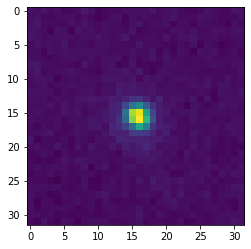

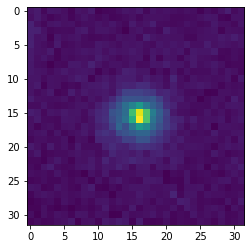

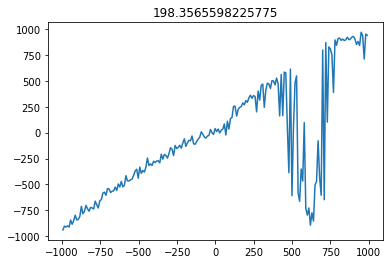

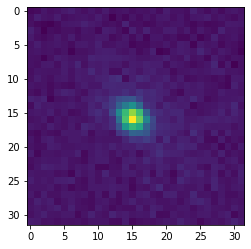

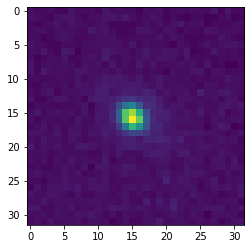

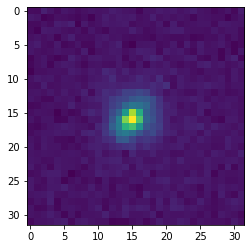

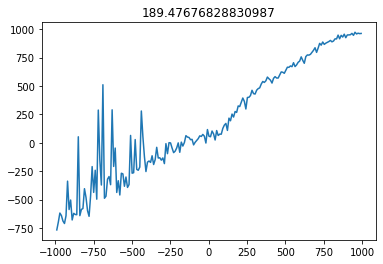

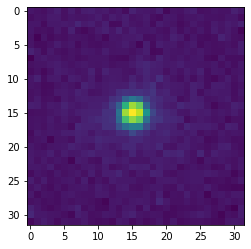

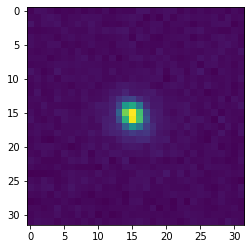

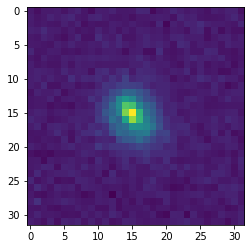

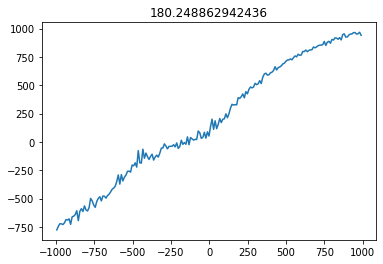

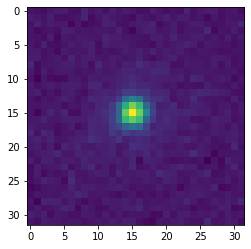

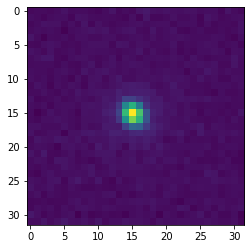

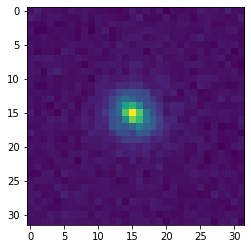

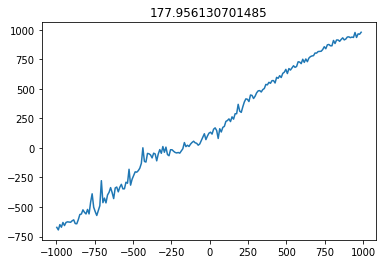

In [10]:
import matplotlib.pyplot as plt
top_10_errors_idx = np.argsort(mean_errors)[::-1][:10]
print([mean_errors[i] for i in top_10_errors_idx])
print('done')
for i in top_10_errors_idx:
    plt.imshow(psfs[i][50])
    plt.show()
    plt.imshow(psfs[i][100])
    plt.show()
    plt.imshow(psfs[i][150])
    plt.show()
    plt.title(str(mean_errors[i]))
    plt.plot(true_ys[i], pred_ys[i])
    plt.show()

(24477, 1)
Mean: 113.54632856637913
Median: 99.8753503597997


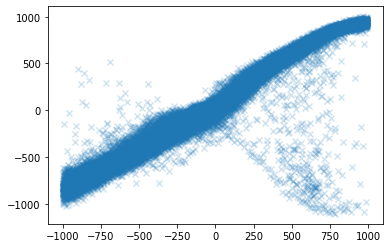

24477
(123,)
(123, 12)


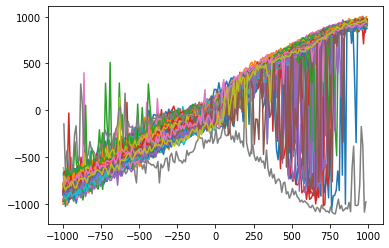

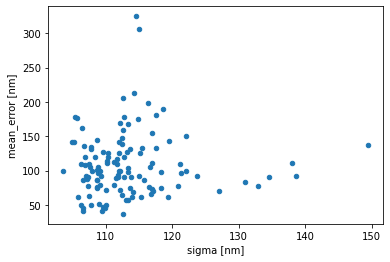

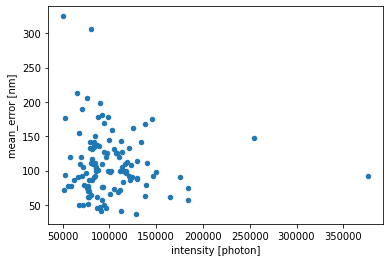

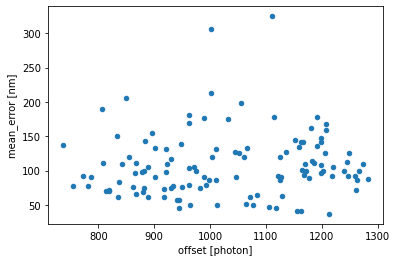

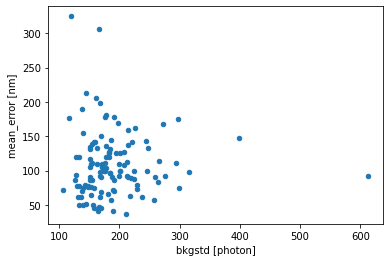

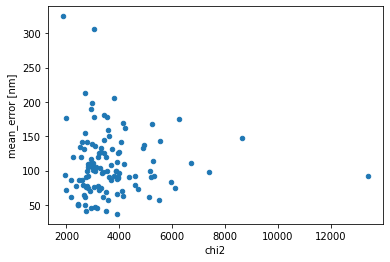

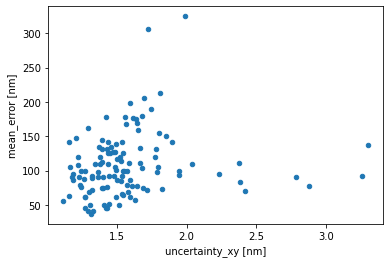

<ipython-input-15-f8eb49398376>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dist_from_center [nm]'] = cdist(middle, sub_df[['x [nm]', 'y [nm]']].to_numpy())[0]


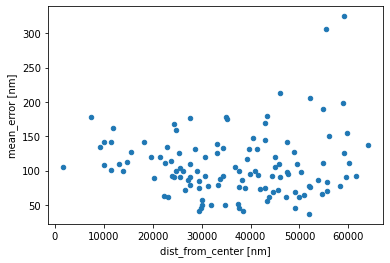

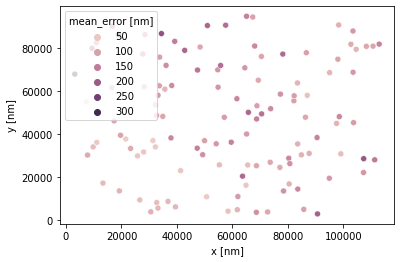

In [15]:
print(f'Mean: {np.mean(mean_errors)}')
print(f'Median: {np.median(mean_errors)}')
plt.scatter(np.stack(true_ys), np.stack(pred_ys), marker='x', alpha=0.2)
plt.show()
print(sum([e.shape[0] for e in exp_dataset.all_psfs]))

print(np.array(mean_errors).shape)
print(df.shape)

df['mean_error [nm]'] = mean_errors
df['log_mean_error'] = np.log(mean_errors)

sub_df = df[df['intensity [photon]'] > 50000]

good_preds = np.where(sub_df['mean_error [nm]'] < 100000)[0]

for i in good_preds:
    t, p = true_ys[i], pred_ys[i]
    plt.plot(t, p, label=str(round(mean_errors[i], 2)))
# plt.legend()
plt.show()

# print(df['mean_error [nm]'])
# img_idx = np.argsort(df['mean_error [nm]'])[::-1][:10]
# for idx in img_idx:
#     plt.title(str(list(df['mean_error [nm]'])[idx]))
#     show_psf_axial(dataset.all_psfs[idx])


cols = ['sigma [nm]', 'intensity [photon]', 'offset [photon]', 'bkgstd [photon]', 'chi2', 'uncertainty_xy [nm]']
for c in cols:
    sub_df.plot.scatter(c, 'mean_error [nm]')
    plt.show()

    
middle = [[np.mean(df['x [nm]']), np.mean(df['y [nm]'])]]

sub_df['dist_from_center [nm]'] = cdist(middle, sub_df[['x [nm]', 'y [nm]']].to_numpy())[0]
sub_df.plot.scatter('dist_from_center [nm]', 'mean_error [nm]')
plt.show()

import seaborn as sns
sns.scatterplot(data=sub_df, x='x [nm]', y='y [nm]', hue='mean_error [nm]')
plt.show()